# Вероятности повторных матчей Кубка Лиги 2024

In [86]:
import pandas as pd
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Загрузим результаты всех матчей МФЛ и МКС и найдем вероятности каждого из счетов

df_matches = pd.read_excel('Датасет матчи MFL.xlsx')

In [110]:
df_matches

,Дата,Турнир,Стадия,Команда 1,Команда 2,Счет,Булитальти,Счет булитальти
0,2022-07-10,MFL-1,Финал,2DROTS,Basement,4:0,False,NaN
1,2022-07-03,MFL-1,1/2 финала,Basement,Арт,4:0,False,NaN
2,2022-07-03,MFL-1,1/2 финала,На Спорте,2DROTS,0:1,False,NaN
3,2022-06-25,MFL-1,1/4 финала,2DROTS,ЛФК Рома,4:0,False,NaN
4,2022-06-25,MFL-1,1/4 финала,Basement,SD Family,3:0,False,NaN
...,...,...,...,...,...,...,...,...
404,2024-10-11,Кубок Надежды,Тур 7,ЭГРИСИ,ТАНДЕМ,0:4,False,NaN
405,2024-10-12,Кубок Надежды,Тур 7,ЧЕРТАНОВО МЕДИА,ФК РОМА,1:5,False,NaN
406,2024-10-13,Кубок Надежды,Тур 7,НАРОДНАЯ КОМАНДА,КОНИ,1:1,True,1:2
407,2024-10-19,Кубок Надежды,Полуфинал,ТАНДЕМ,НАРОДНАЯ КОМАНДА,2:1,False,NaN


In [109]:
# количество матчей в парах Кубка Лиги
df_matches_mflcup = df_matches[df_matches['Турнир']=='Кубок Лиги']

df_matches_mflcup['team_pair'] = df_matches_mflcup.apply(lambda row: tuple(sorted([row['Команда 1'], row['Команда 2']])), axis=1)
match_counts_cupmfl = df_matches_mflcup.groupby('team_pair').size().reset_index(name='match_count').sort_values(by='match_count', ascending=False)
match_counts_cupmfl

/var/folders/89/k2_wkj_s18n7sw9fnbmysbjc0000gp/T/ipykernel_34594/1086078788.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_matches_mflcup['team_pair'] = df_matches_mflcup.apply(lambda row: tuple(sorted([row['Команда 1'], row['Команда 2']])), axis=1)


,team_pair,match_count
1,"(2DROTS, Fight Nights)",5
24,"(Lotus, Rocket Team)",3
33,"(Родина Медиа, ФК 10)",3
15,"(DMedia, Чисто Питер)",3
37,"(СКА-Ростов, Чисто Питер)",2
25,"(Lotus, Амкал)",2
8,"(Broke Boys, ФК 10)",2
22,"(LIT Energy, СКА-Ростов)",2
30,"(Rocket Team, ФК Банка)",2
0,"(2DROTS, Broke Boys)",1


#### Нахождение вероятностей определенного счета в МФЛ/МКС

In [4]:
# Приведем все счета к одному формату, где первое число больше второго (0:4 -> 4:0)
def max_score (score):
    s1, s2 = score.split(':')
    s1, s2 = int(s1), int(s2)
    score_minmax = f'{max(s1, s2)}:{min(s1, s2)}'
    return score_minmax
df_scores = pd.DataFrame()
df_scores['score'] = df_matches['Счет'].apply(max_score)
df_scores

,score
0,4:0
1,4:0
2,1:0
3,4:0
4,3:0
...,...
404,4:0
405,5:1
406,1:1
407,2:1


In [5]:
# Найдем вероятность опреденного счета в матче
df_score_group = df_scores.groupby(by='score').agg(count_score=('score', 'count')).reset_index()
df_score_group['total_matches'] = df_score_group['count_score'].sum()
df_score_group['probability'] = df_score_group['count_score'] / df_score_group['total_matches']
df_score_probability = df_score_group[['score', 'count_score', 'probability']].sort_values(by='probability', ascending=False)
df_score_probability

,score,count_score,probability
5,2:1,63,0.154034
2,1:0,56,0.136919
3,1:1,47,0.114914
4,2:0,44,0.107579
0,0:0,30,0.073350
7,3:0,27,0.066015
8,3:1,20,0.048900
9,3:2,16,0.039120
11,4:0,13,0.031785
6,2:2,12,0.029340


#### Вспомогательные функции для моделирования результатов турнира

In [6]:
# Функция определения победителя матча
def simulate_match(team1, team2):
    scores = df_score_probability['score'].tolist()
    probabilities = df_score_probability['probability'].tolist()

    chosen_score = np.random.choice(scores, p=probabilities)
    high_goals, low_goals = map(int, chosen_score.split(':'))

    # если ничья
    if high_goals == low_goals:
        winner = random.choice([team1, team2])
        team1_goals = team2_goals = high_goals
        bullitalti = True
    # если победа одной из команд
    else:
        if random.choice([True, False]):
            team1_goals, team2_goals = high_goals, low_goals
            winner = team1
        else:
            team1_goals, team2_goals = low_goals, high_goals
            winner = team2
        bullitalti = False

    return team1_goals, team2_goals, winner, bullitalti

In [7]:
# Функция генерации матчей на тур
def generate_matches(teams):
    return [
        (teams[0], teams[5]),  # 1-е место против 6-го
        (teams[1], teams[4]),  # 2-е место против 5-го
        (teams[2], teams[3]),  # 3-е место против 4-го
        (teams[6], teams[7]),  # 7-е место против 8-го
        (teams[8], teams[13]),  # 9-е место против 14-го
        (teams[9], teams[12]),  # 10-е место против 13-го
        (teams[10], teams[11])  # 11-е место против 12-го
    ]

In [8]:
# Распределение очков по командам
def update_points(team1, team2, s1, s2, winner, bullit, teams_data):
    teams_data[team1]['goal_diff'] += (s1 - s2)
    teams_data[team2]['goal_diff'] += (s2 - s1)
    
    loser = team2 if winner == team1 else team1
    if s1 == s2:  
        teams_data[winner]['points'] += 2 
        teams_data[loser]['points'] += 1 
    else:
        teams_data[winner]['points'] += 3  
        teams_data[loser]['points'] += 0 

    update_head_to_head(winner, loser, teams_data, 'won')
    update_head_to_head(loser, winner, teams_data, 'lost')

# Обновление данных о личных встречах
def update_head_to_head(team, opponent, teams_data, result):
    if opponent not in teams_data[team]['head_to_head']:
        teams_data[team]['head_to_head'][opponent] = {'won': 0, 'lost': 0}
    teams_data[team]['head_to_head'][opponent][result] += 1

In [9]:
# функция обновления мест в таблице
def update_table(teams_data):
    def compare_teams(team1, team2):
        if teams_data[team1]['points'] > teams_data[team2]['points']:
            return -1
        elif teams_data[team1]['points'] < teams_data[team2]['points']:
            return 1
        
        head_to_head = teams_data[team1]['head_to_head'].get(team2, {'won': 0, 'lost': 0})
        if head_to_head['won'] > head_to_head['lost']:
            return -1
        elif head_to_head['won'] < head_to_head['lost']:
            return 1 

        if teams_data[team1]['goal_diff'] > teams_data[team2]['goal_diff']:
            return -1
        elif teams_data[team1]['goal_diff'] < teams_data[team2]['goal_diff']:
            return 1
        
        return 0
    
    sorted_teams = sorted(teams_data.keys(), key=lambda team: (teams_data[team]['points'], (teams_data[team]['goal_diff'])), reverse=True)
    sorted_teams = sorted(sorted_teams, key=lambda team: compare_teams(team, sorted_teams[0]))
    
    # for team in sorted_teams:
    #     print(team)
    #     import json
    #     print(json.dumps(teams_data[team], indent=4, ensure_ascii=False))

    return sorted_teams

In [10]:
# Запуск турнира, на выходе результаты каждого тура
def run_tournament(teams, n_tours=8):
    teams_data = {team: {'points': 0, 'goal_diff': 0, 'head_to_head': {}} for team in teams}
    results = []
    
    for tour in range(1, n_tours + 1):
        matches = generate_matches(teams)
        for team1, team2 in matches:
            s1, s2, winner, bullit = simulate_match(team1, team2)
            results.append({
                'Тур': tour,
                'Команда 1': team1,
                'Команда 2': team2,
                'Счет матча': f'{s1}:{s2}',
                'Победитель': winner,
                'Буллитальти': bullit
            })
            
            # Обновляем очки и данные о командах
            update_points(team1, team2, s1, s2, winner, bullit, teams_data)
        
        # Обновляем турнирную таблицу
        teams = update_table(teams_data)

    df_results = pd.DataFrame(results)
    return df_results

#### Моделирование турнира

In [19]:
# получение результатов каждого каждого матча во всех смоделированных турнирах
teams = ["АМКАЛ", "BROKE BOYS", "ЧИСТО ПИТЕР", "ФК БАНКА", "РОДИНА МЕДИА", "2DROTS", "LIT ENERGY", "СКА-РОСТОВ", 
         "FC DMEDIA", "FIGHT NIGHTS", "ROCKET TEAM", "LOTUS", "ТИТАН", "ФК 10"]

total_tourn_count = pd.DataFrame()
for tourn in tqdm(range(0, 100000), desc='Симуляция турниров'):
    df_tournament_results = run_tournament(teams)
    df_tournament_results['team_pair'] = df_tournament_results.apply(lambda row: tuple(sorted([row['Команда 1'], row['Команда 2']])), axis=1)
    match_counts = df_tournament_results.groupby('team_pair').size().reset_index(name='match_count').sort_values(by='match_count', ascending=False)
    match_distribution = match_counts.groupby('match_count').size().reset_index(name='pair_count').sort_values(by='pair_count', ascending=False)
    match_distribution['tourn_num'] = tourn + 1
    total_tourn_count = pd.concat([match_distribution, total_tourn_count])


Симуляция турниров: 100%|██████████| 100000/100000 [04:27<00:00, 374.21it/s]


In [111]:
total_tourn_count

,match_count,pair_count,tourn_num
0,1,29,100000
1,2,6,100000
2,3,5,100000
0,1,26,99999
1,2,12,99999
...,...,...,...
3,4,1,2
0,1,17,1
1,2,14,1
3,4,2,1


In [112]:
# добавление мнимых строк в датасет
tournaments = total_tourn_count['tourn_num'].unique()
match_counts = range(1, 9)
full_data = pd.MultiIndex.from_product([match_counts, tournaments], names=['match_count', 'tourn_num']).to_frame(index=False)
merged_df = pd.merge(full_data, total_tourn_count, on=['match_count', 'tourn_num'], how='left')
merged_df['pair_count'] = merged_df['pair_count'].fillna(0)
merged_df

,match_count,tourn_num,pair_count
0,1,100000,29.0
1,1,99999,26.0
2,1,99998,30.0
3,1,99997,25.0
4,1,99996,26.0
...,...,...,...
799995,8,5,0.0
799996,8,4,0.0
799997,8,3,0.0
799998,8,2,0.0


In [117]:
# расчет вероятности появления определенного количества повторных матчей между командами во всех турнирах
total_tourn_res = total_tourn_count.copy()
total_res = total_tourn_res.groupby('match_count').agg(in_tourn_count=('match_count', 'size')).reset_index()
total_res['tourn_count_total'] = total_tourn_res['tourn_num'].max()
total_res['Вероятность появления матча'] = round(total_res['in_tourn_count'] / total_res['tourn_count_total'], 5) * 100
table_screen = total_res[['match_count', 'in_tourn_count', 'Вероятность появления матча']]
table_screen.columns = ['Кол-во повторяющихся матчей', 'В скольких турнирах встречалось такое количество?', 'Вероятность появления матча']
table_screen

,Кол-во повторяющихся матчей,В скольких турнирах встречалось такое количество?,Вероятность появления матча
0,1,100000,100.000
1,2,99999,99.999
2,3,94694,94.694
3,4,46509,46.509
4,5,10673,10.673
5,6,1119,1.119
6,7,1,0.001


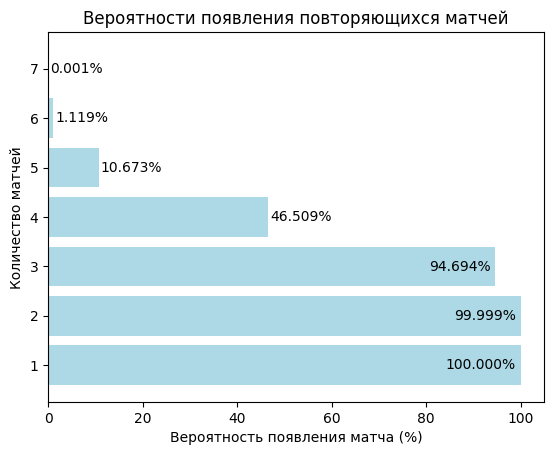

In [108]:
plt.barh(match_count, probability, color='lightblue')

for i, v in enumerate(probability):
    if match_count[i] <= 3: 
        plt.text(v - 1, match_count[i], f'{v:.3f}%', va='center', ha='right', color='black') 
    else: 
        plt.text(v + 0.5, match_count[i], f'{v:.3f}%', va='center', ha='left', color='black')

plt.xlabel('Вероятность появления матча (%)')
plt.ylabel('Количество матчей')
plt.title('Вероятности появления повторяющихся матчей')
#plt.grid(True)
plt.show()

In [47]:
df_group_2

,match_count,avg_match,median_match,min_match,max_match
0,1,27.11200,27.0,9.0,48.0
1,2,9.07735,9.0,0.0,19.0
2,3,2.55040,2.0,0.0,9.0
3,4,0.61118,0.0,0.0,6.0
4,5,0.11383,0.0,0.0,4.0
5,6,0.01136,0.0,0.0,2.0
6,7,0.00001,0.0,0.0,1.0
7,8,0.00000,0.0,0.0,0.0


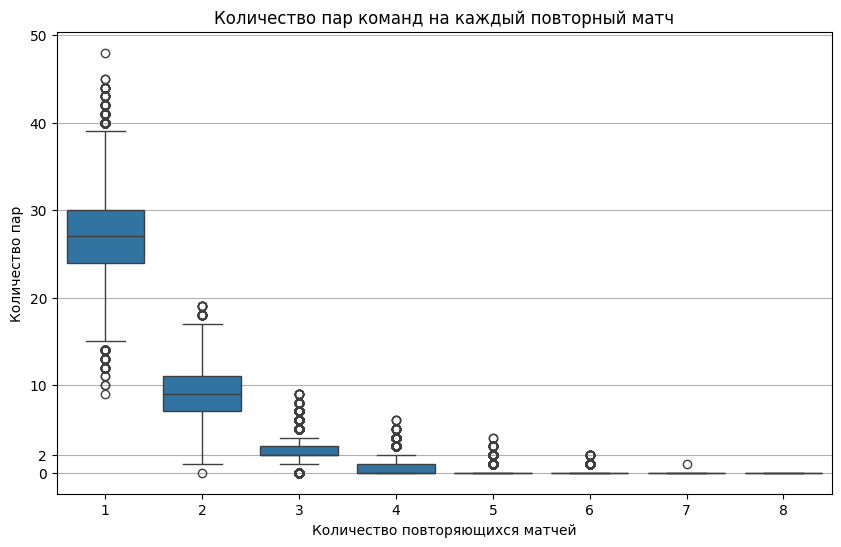

In [119]:
# Сколько в среднем за турнир играют повторных матчей
df_group_2 = merged_df.groupby(by='match_count').agg(avg_match=('pair_count', 'mean'),
                                                           median_match=('pair_count', 'median'),
                                                           min_match=('pair_count', 'min'),
                                                           max_match=('pair_count', 'max'),).reset_index()

plt.figure(figsize=(10,6))
plt.grid()
sns.boxplot(x=merged_df['match_count'], y=merged_df['pair_count'])
plt.title('Количество пар команд на каждый повторный матч')
plt.xlabel('Количество повторяющихся матчей')
plt.ylabel('Количество пар')
plt.yticks([0, 2, 10, 20, 30, 40, 50])
#plt.bar(df_group_2['match_count'], df_group_2['avg_match'])

plt.show()

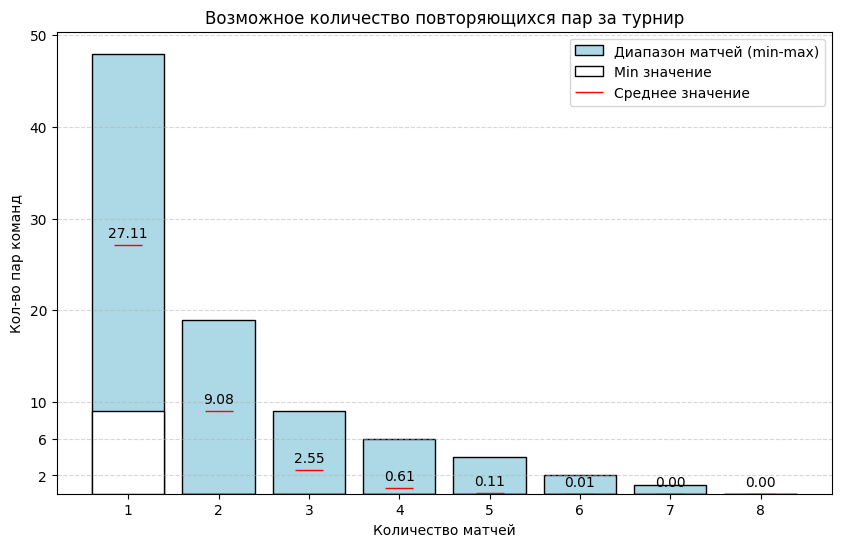

In [125]:
plt.figure(figsize=(10,6))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.bar(df_group_2['match_count'], df_group_2['max_match'], color='lightblue', edgecolor='black', label='Диапазон матчей (min-max)')
plt.bar(df_group_2['match_count'], df_group_2['min_match'], color='white', edgecolor='black', label='Min значение')

plt.errorbar(df_group_2['match_count'], df_group_2['avg_match'], fmt='_', color='red', label='Среднее значение', markersize=20, capsize=5)

for x, y in zip(df_group_2['match_count'], df_group_2['avg_match']):
    plt.text(x, y + 0.5, f'{y:.2f}', ha='center', va='bottom', color='black')

plt.yticks([2, 6, 10, 20, 30, 40, 50])
plt.xlabel('Количество матчей')
plt.ylabel('Кол-во пар команд')
plt.title('Возможное количество повторяющихся пар за турнир')
plt.legend()

plt.show()